In [8]:
import sys
sys.path.append('../code/functions')

import cv2
import pickle

from connectLib import otsuVox
from connectLib import clusterThresh
from random import randrange as rand
from cluster import Cluster

import mouseVis as mv
import numpy as np
import matplotlib.pyplot as plt

# Simulation Code
The code below will generate a test folume and populate it with a set of clusters.

In [5]:
def generatePointSet():
    center = (rand(0, 9), rand(0, 999), rand(0, 999))
    toPopulate = []
    for z in range(-3, 2):
        for y in range(-3, 2):
            for x in range(-3, 2):
                curPoint = (center[0]+z, center[1]+y, center[2]+x)
                #only populate valid points
                valid = True
                for dim in range(3):
                    if curPoint[dim] < 0 or curPoint[dim] >= 1000:
                        valid = False
                if valid:
                    toPopulate.append(curPoint)
    return set(toPopulate)
    
def generateTestVolume():
    #create a test volume
    volume = np.zeros((10, 1000, 1000))
    myPointSet = set()
    for _ in range(rand(1000, 2000)):
        potentialPointSet = generatePointSet()
        #be sure there is no overlap
        while len(myPointSet.intersection(potentialPointSet)) > 0:
                potentialPointSet = generatePointSet()
        for elem in potentialPointSet:
            myPointSet.add(elem)
    #populate the true volume
    for elem in myPointSet:
        volume[elem[0], elem[1], elem[2]] = rand(40000, 60000)
    #introduce noise
    noiseVolume = np.copy(volume)
    for z in range(noiseVolume.shape[0]):
        for y in range(noiseVolume.shape[1]):
            for x in range(noiseVolume.shape[2]):
                if not (z, y, x) in myPointSet:
                    toPop = rand(0, 10)
                    if toPop == 5:
                        noiseVolume[z][y][x] = rand(0, 60000)
    return volume, noiseVolume

# Cluster Extraction Validation
First, be sure that our cluster extraction algorithm works as intended on the test volume

In [6]:
myTestVolume, _ = generateTestVolume()

In [9]:
#passed arbitrarily large param for upper bound to get all clusters
testList = clusterThresh(myTestVolume, 0, 100000)

In [10]:
#generate an annotation volume from the test list
annotations = mv.generateAnnotations(testList, *(myTestVolume.shape))

In [15]:
print np.count_nonzero(np.logical_xor(annotations, myTestVolume))

0


The nonzero xor between the volumes proves that clustering the volume maintains the integrity of the cluster lists. This test is run 5 times in a row below to validate that the 0 difference metric is valid across trials

In [17]:
for i in range(5):
    myTestVolume,  _ = generateTestVolume()
    testList = clusterThresh(myTestVolume, 0, 100000)
    annotations = mv.generateAnnotations(testList, *(myTestVolume.shape))
    print np.count_nonzero(np.logical_xor(annotations, myTestVolume))

0
0
0
0
0


The set of 5 zeros validates that the error in the F1 code is not the extraction of the cluster lists

# Precision Recall F1 2.0

In [47]:
def precision_recall_f1(labels, predictions, overlapRatio):
   

    if len(predictions) == 0:
        print 'ERROR: prediction list is empty'
        return 0., 0., 0.
    
    labelFound = np.zeros(len(labels))
    truePositives = 0
    falsePositives = 0

    for prediction in predictions:
        #casting to set is ok here since members are uinque
        predictedMembers = set([tuple(elem) for elem in prediction.getMembers()])
        detectionCutoff = overlapRatio * len(predictedMembers)
        found = False
        
        for idx, label in enumerate(labels):
            labelMembers = set([tuple(elem) for elem in label.getMembers()])
            #if the predictedOverlap is over the detectionCutoff ratio
            if len(predictedMembers & labelMembers) >= detectionCutoff:
                truePositives +=1
                found=True
                labelFound[idx] = 1
        
        if not found:
            falsePositives +=1
            
    precision = truePositives/float(truePositives + falsePositives)
    recall = np.count_nonzero(labelFound)/float(len(labels))
    #f1 = 2 * (precision*recall)/(precision + recall)

    return precision, recall, f1

# Precision Recall F1 2.0 Testing

First, the algorithm will be tested on a case where it should get 100% precision and 100% recall

In [48]:
myTestVolume,  _ = generateTestVolume()
testList = clusterThresh(myTestVolume, 0, 100000)

#run the code on a test volume identical labels
precision, recall, f1 = precision_recall_f1(testList, testList, 1)

In [49]:
print precision, recall, f1

1.0 1.0 1.0


The 1 precision, recall and f1 metrics show that the algorithm performs as expected on the case of labels being their own predicions

Next, the recall will be tested by randomly selecting a percentile of the true clusters to be passed to the prediction. This should modulate only the recall, and not the precision, of the data, as all clusters being passed are still "correct" predictions. If the algorithm works as expected, I should see a constant precision metric and an upwardly sloping recall metric with slope of 10% That is, for every additional 10% of the labels included in the predictions, the recall sould increase by 10%

In [52]:
statList = []
for i in range(1, 11):
    percentile = i/10.
    predictions = np.random.choice(testList, int(percentile * len(testList)), replace=False)
    precision, recall, f1 = precision_recall_f1(testList, predictions, 1)
    statList.append([percentile, precision, recall])
    print 'Percentile: ', percentile
    print '\t precision: ', precision
    print '\t recall: ', recall

Percentile:  0.1
	 precision:  1.0
	 recall:  0.0998248686515
Percentile:  0.2
	 precision:  1.0
	 recall:  0.199649737303
Percentile:  0.3
	 precision:  1.0
	 recall:  0.299474605954
Percentile:  0.4
	 precision:  1.0
	 recall:  0.399299474606
Percentile:  0.5
	 precision:  1.0
	 recall:  0.5
Percentile:  0.6
	 precision:  1.0
	 recall:  0.599824868651
Percentile:  0.7
	 precision:  1.0
	 recall:  0.699649737303
Percentile:  0.8
	 precision:  1.0
	 recall:  0.799474605954
Percentile:  0.9
	 precision:  1.0
	 recall:  0.899299474606
Percentile:  1.0
	 precision:  1.0
	 recall:  1.0


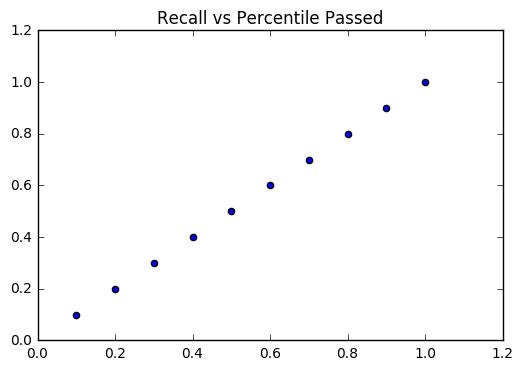

In [54]:
fig = plt.figure()
elemwiseStats = zip(*(statList))
plt.title('Recall vs Percentile Passed')
plt.scatter(elemwiseStats[0], elemwiseStats[2])
plt.show()

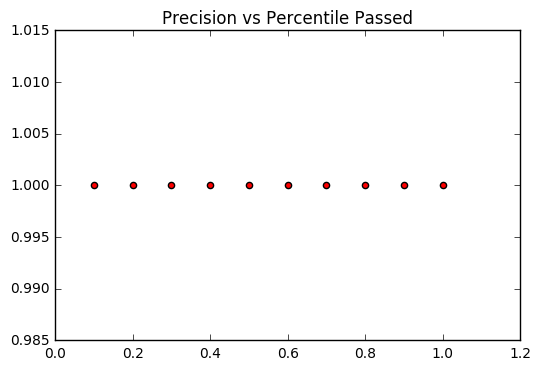

In [55]:
fig = plt.figure()
plt.title('Precision vs Percentile Passed')
plt.scatter(elemwiseStats[0], elemwiseStats[1], c='r')
plt.show()

The linearly increasing nature of recall plot demonstrates that the recall portion of the code indeed corresponds to the ratio of true labels passed in.

Additionally, the precision plot being constant shows that modulating only the recall has no affect on the precision of the data

Next, the data will be diluted such that it contains a portion of noise clusters. This should change the precision, but not the recall, of the data. If this algorithm works as expected, it will produce a constant recall and a downward sloping precision curve with a slope of 10%. That is, for every additional 10% of noise added to the predictions, the precision should drop by 10%


In [67]:
statList = []

#get list points in data that I can populate noise clusters with
noCluster = zip(*(np.where(myTestVolume == 0)))

for i in range(0, 10):
    #get the number of noise clusters that must be added for data to be diluted
    #to target percent
    percentile = i/10.
    numNoise = int(percentile * len(testList)/float(1-percentile))
    
    #generate the prediction + noise list
    noiseList =[]
    for j in range(numNoise):
        badPoint = noCluster[rand(0, len(noCluster)-1)]
        noiseList.append(Cluster([list(badPoint)]))
    predictions = testList + noiseList
    
    precision, recall, f1 = precision_recall_f1(testList, predictions, 1)
    statList.append([percentile, precision, recall])
    print 'Percentile: ', percentile
    print '\t precision: ', precision
    print '\t recall: ', recall

Percentile:  0.0
	 precision:  1.0
	 recall:  1.0
Percentile:  0.1
	 precision:  0.900630914826
	 recall:  1.0
Percentile:  0.2
	 precision:  0.800280308339
	 recall:  1.0
Percentile:  0.3
	 precision:  0.700183936235
	 recall:  1.0
Percentile:  0.4
	 precision:  0.600105097215
	 recall:  1.0
Percentile:  0.5
	 precision:  0.5
	 recall:  1.0
Percentile:  0.6
	 precision:  0.40014015417
	 recall:  1.0
Percentile:  0.7
	 precision:  0.300052548607
	 recall:  1.0
Percentile:  0.8
	 precision:  0.2
	 recall:  1.0
Percentile:  0.9
	 precision:  0.1
	 recall:  1.0


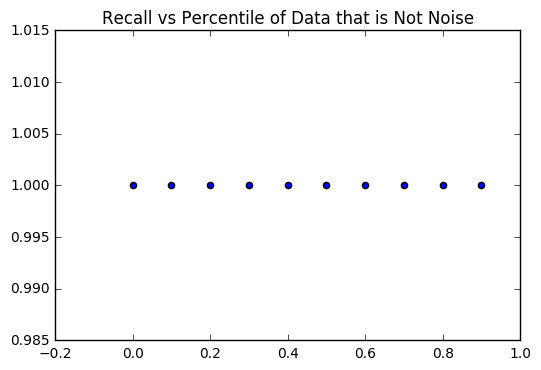

In [79]:
fig = plt.figure()
elemwiseStats = zip(*(statList))
plt.title('Recall vs Percentile of Data that is Not Noise')
plt.scatter(elemwiseStats[0], elemwiseStats[2])
plt.show()

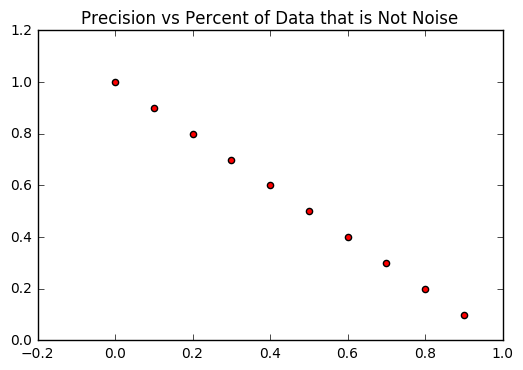

In [78]:
fig = plt.figure()
plt.title('Precision vs Percent of Data that is Not Noise')
plt.scatter(elemwiseStats[0], elemwiseStats[1], c='r')
plt.show()

As these plots demonstrate, adding noise to the list of all true clusters delivers the expected result, that the precision drops, and the recall remains constant.

In our data, there is not a guarantee that the predicted clusters and the actual clusters will exactly overlap. In fact, this is likely not the case. However, we would not like to consider a cluster a false positive if it only differs from the true cluster by one pixel. For this reason, I have included an overlapRatio parameter to vary how much overlap between a prediction and a true cluster must exist for the prediction to be considered correct

In the following simulation, the cluster labels will be evenly divided and then eroded between 10% and 100%. I will then run the precision recall code against them with an ever increasing percent overlap metric. If the code works, I expect both the precision and the recall to drop by about 10% for every 10% increase in the percent overlap metric.

In [85]:
statList = []

#generate the list of eroded clusters
erodedList = []
for idx, cluster in enumerate(testList):
    percentile = (idx%10)/10. + .1
    members = cluster.getMembers()
    erodedList.append(Cluster(members[:int(len(members)*percentile)]))

In [86]:
for i in range(1, 11):
    percentile = i/10.   
    precision, recall, f1 = precision_recall_f1(erodedList, testList, percentile)
    statList.append([percentile, precision, recall])
    print 'Percentile: ', percentile
    print '\t precision: ', precision
    print '\t recall: ', recall

Percentile:  0.1
	 precision:  0.919439579685
	 recall:  0.919439579685
Percentile:  0.2
	 precision:  0.899299474606
	 recall:  0.899299474606
Percentile:  0.3
	 precision:  0.72591943958
	 recall:  0.72591943958
Percentile:  0.4
	 precision:  0.69877408056
	 recall:  0.69877408056
Percentile:  0.5
	 precision:  0.517513134851
	 recall:  0.517513134851
Percentile:  0.6
	 precision:  0.499124343257
	 recall:  0.499124343257
Percentile:  0.7
	 precision:  0.319614711033
	 recall:  0.319614711033
Percentile:  0.8
	 precision:  0.221541155867
	 recall:  0.221541155867
Percentile:  0.9
	 precision:  0.121716287215
	 recall:  0.121716287215
Percentile:  1.0
	 precision:  0.0998248686515
	 recall:  0.0998248686515


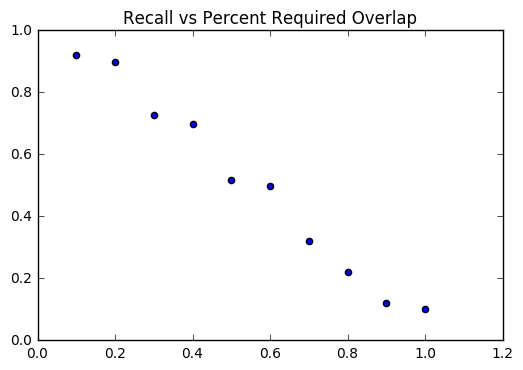

In [87]:
fig = plt.figure()
elemwiseStats = zip(*(statList))
plt.title('Recall vs Percent Required Overlap')
plt.scatter(elemwiseStats[0], elemwiseStats[2])
plt.show()

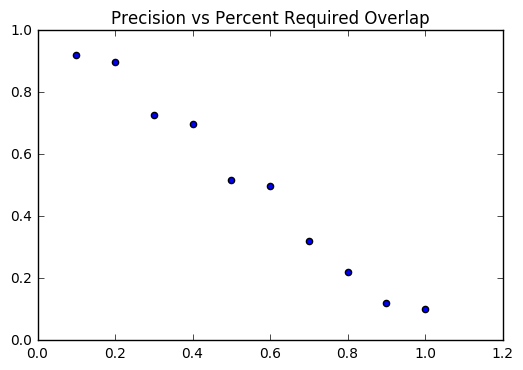

In [88]:
fig = plt.figure()
elemwiseStats = zip(*(statList))
plt.title('Precision vs Percent Required Overlap')
plt.scatter(elemwiseStats[0], elemwiseStats[1])
plt.show()